This cell will import all of the needed libraries for this lab. These include pyserial for serial communication, NumPy for Fast Fourier Transform and array processing, and matplotlib.pyplot for plotting.

In [2]:
from serial import Serial
import time
import numpy as np
from matplotlib import pyplot as plt

These parameters will be sent to the microcontroller to generate the sine
sweep. Uncomment the lines for your pendulum.

In [1]:
# Short Pendulums
# f_start = 2.5
# f_end = 8
# Long Pendulums
# f_start = 2
# f_end = 6
interval = 15
points_per_second = 100
points = interval * points_per_second

This section will reset the microcontroller, send the sine sweep parameters, and then record the data sent back to a file.

In [4]:
# Uncomment this line and give the name of the serial port which the Nucleo
# is connected to, as a string. This should be something like
# 'COMx' for Windows and
# '/dev/tty.usbmodemXXXX' for Mac/Linux
# Windows: Open Device Manager and look under "Ports (COM & LPT)" for a 
# "USB Serial Device"
# Mac/Linux: Open terminal and run "ls /dev/tty.*" to find the port matching the
# format above.
serport = 'COM3'

# Filename to store data in
filename = 'data.csv'

# Open the serial port, and give it the name ser.
with Serial(serport, baudrate=115200, timeout=5) as ser:
    # Write ^B^D to stop program and reset the microcontroller
    ser.write(b'\x02\x04')
    # Write all parameters followed by enter
    ser.write((str(f_start) + '\r\n').encode())
    ser.write((str(f_end) + '\r\n').encode())
    ser.write((str(interval) + '\r\n').encode())
    ser.write((str(points) + '\r\n').encode())
    # Open the data file for writing, and give it the name datafile
    with open(filename, 'w') as datafile:
        while True:
            # Read the current line and decode from bytes to a string
            line = ser.readline().decode()
            # Print the line so we can see what the microcontroller is doing
            # print(line, end='')
            # If the line starts with END, then we know the data is complete
            if line[:3] == 'END':
                break
            # If the line has a comma, it is a line of CSV data.
            elif ',' in line:
                datafile.write(line.strip() + '\n')

Read the data from the CSV file, and give names to each of the different collumns.

In [5]:
data = np.genfromtxt('data.csv', delimiter=',')

times = data[:,0]
sweep = data[:,1]
positions = data[:,2]

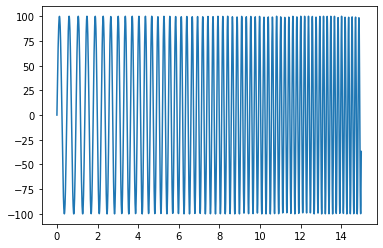

In [6]:
plt.plot(times, sweep)

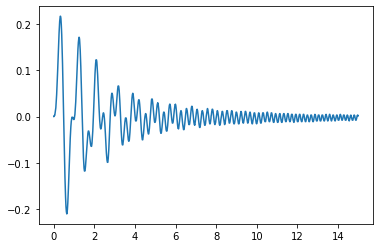

In [7]:
plt.plot(times, positions)

In [9]:
def fft_for_bode(times, input_data, output_data):
    ''' Runs a Fast Fourier Transform on input and output and returns
        the results in a form that makes it easy to draw a Bode plot.
        
        Args:
            input_data:   Series of points for the excitation signal applied
                          to the input of the system
            output_data:  Series of points for the system output signal.
        Both the input and output should be at the same constant sample rate.
            
        Returns:
            A tuple (frequencies, magnitude_db, phase) where
                frequencies is the x-axis of bode plot
                magnitude_db is the magnitude of output/input, in (dB)
                phase is the phase difference between output and input, (deg)
    '''
    # Get the sample period by subracting the two first times
    dt = (times[1] - times[0])
    # Get the frequencies that the FFT will use
    frequencies = np.fft.rfftfreq(len(times), d=dt)

    # Calculate the FFT for both the sweep input and position output
    # Returns an array of complex numbers (phasors)
    input_fft = np.fft.rfft(input_data)
    output_fft = np.fft.rfft(output_data)

    # Divide the output by the input (elementwise)
    # to get the response, as a complex array
    response = output_fft / input_fft
    # Convert the complex numbers into magnitude and phase representation
    magnitude = np.abs(response)
    phase = np.angle(response, deg=True)
    # Convert the magnitude to decibels
    magnitude_db = 20 * np.log10(magnitude)
    # Return 3-tuple of results
    return frequencies, magnitude_db, phase

In [10]:
frequencies, magnitude_db, phase = fft_for_bode(times, sweep, positions)

This cell will calculate the expected response based on the model
$$\frac{K_{ss}\omega_n^2}{s^2 +2\zeta\omega_n s + \omega_n^2}$$

In [11]:
model_freq = np.logspace(-1, 1, 1000)
s = 1.0j * 2 * np.pi * model_freq
K_ss = 0.003
omega_n = 1.03 * 2 * np.pi
zeta = 0.1
G = K_ss * omega_n ** 2 / (s ** 2 + 2 * zeta * omega_n * s + omega_n ** 2)
model_mag = 20 * np.log10(np.abs(G))
model_phase = np.angle(G, deg=True)

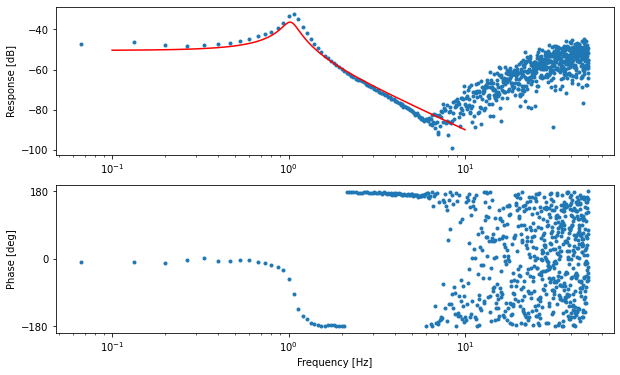

In [12]:
plt.rcParams['figure.figsize'] = (10, 6)
plt.subplot(2, 1, 1)
plt.semilogx(frequencies, magnitude_db, '.')
# plt.xlim(0.1, f_end)
plt.plot(model_freq, model_mag, 'r-')
plt.ylabel("Response [dB]")

plt.subplot(2, 1, 2)
plt.semilogx(frequencies, phase, '.')
# plt.xlim(0.1, f_end)
plt.yticks([-180, 0, 180])
# plt.semilogx(model_freq, model_phase, 'r-')
plt.xlabel("Frequency [Hz]")
plt.ylabel("Phase [deg]")
plt.savefig('expbode.svg')
plt.show()